# Introduction
### Dataset
### Goals

## Data Loading and Formatting

Before we do anything, we need to load the credit card customer data properly. The `load_credit_card_customer_data` checks to see if the data file `BankChurners.csv` has already been downloaded and if not, it downloads it from `zenodo.org`. Initially we had this function return an `X, y` but it returns a `pandas` dataframe. This is because it's easier to index a `pandas` with the columns that we want to select, this functionality is present in `select_features`. We then select personal features that we want to use as information to predict a financial feature.

In [2]:
import os
import requests
import pandas as pd
import numpy as np

def load_credit_card_customer_data():
    filename = "BankChurners.csv"
    if not os.path.exists(filename):
        url = "https://zenodo.org/records/4322342/files/BankChurners.csv?download=1"
        response = requests.get(url)
        with open(filename, "wb") as f:
            f.write(response.content)

    data = pd.read_csv(filename)
    return data

def select_features(data, X_features, y_label):
    X = data[X_features].values
    y = data[y_label].values
    
    return X, y

data = load_credit_card_customer_data()

personal_features = [
    'Attrition_Flag',
    'Customer_Age',
    'Gender',
    'Dependent_count',
    'Education_Level',
    'Marital_Status',
    'Income_Category',
    'Total_Relationship_Count'
]

labels_column = 'Credit_Limit'

X, y = select_features(data, personal_features, labels_column)
X.shape, y.shape

((10127, 8), (10127,))

Here we can see that we have the `8` personal features and `1` label column. Also there is `10127` rows in this dataset which is pretty big. However, we can see that some of the columns contain categorical data. For example, the `'Attrition_Flag'` will contain either `'Existing Customer'` or `'Attrited Customer'` and the `Gender` column will only include `M` or `F` and so on with `'Education_Level'`, `'Marital_Status'` and `'Income_Category'`.

In [44]:
pd.DataFrame(X[:5, :], columns=personal_features)

,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Total_Relationship_Count
0,Existing Customer,45,M,3,High School,Married,$60K - $80K,5
1,Existing Customer,49,F,5,Graduate,Single,Less than $40K,6
2,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,4
3,Existing Customer,40,F,4,High School,Unknown,Less than $40K,3
4,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,5


#### Transform Categorical Data to Numerical Data

Classifiers like `SVM` can only interpret numerical data and not strings like `"Existing Customer"`. So we need to convert these categorical features to binary categorical data using `OneHotEncoder`. This will create $n$ columns for $n$ different categories in the categorical column and label the entries with either $1$ or $0$ depending on if the entry is in that category. Here is an example with `'Income Category'`.

In [46]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()

income_category = X[:, 6]
X_2darray = np.reshape(income_category, (-1, 1)) 

one_hot_encoded = encoder.fit_transform(X_2darray).toarray()

pd.DataFrame(one_hot_encoded[:5, :], columns=encoder.categories_)

,$120K +,$40K - $60K,$60K - $80K,$80K - $120K,Less than $40K,Unknown
0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0


Here we can see that there are `6` different income categories as the `OneHotEncoder` as created `6` new columns each with either a `1` or a `0` which implies that an entry contains that column. But we want to numericalize all of our categorical data, not just `'Income Category'`.

In [5]:
from sklearn.preprocessing import OneHotEncoder

def one_hot_encode(col):
    encoder = OneHotEncoder()
    reshaped_col = np.reshape(col, (-1, 1))
    numerical_col = encoder.fit_transform(reshaped_col).toarray()
    return encoder.categories_, numerical_col

headers = data.columns

attribution_flag_categories, attribution_flag_numerical = one_hot_encode(X[:, 0])

# age is already numerical
age_categories, age_numerical = headers[2], np.reshape(X[:, 1], (-1, 1))

gender_categories, gender_numerical = one_hot_encode(X[:, 2])

# dependant count is already numerical
dependant_count_categories, dependant_count_numerical = headers[4], np.reshape(X[:, 3], (-1, 1))

education_categories, education_numerical = one_hot_encode(X[:, 4])
maritial_categories, maritial_numerical = one_hot_encode(X[:, 5])
income_categories, income_numerical = one_hot_encode(X[:, 6])

X_numerical = np.hstack((
    attribution_flag_numerical,
    age_numerical,
    gender_numerical,
    dependant_count_numerical,
    education_numerical,
    maritial_numerical,
    income_numerical
))

headers = \
    attribution_flag_categories[0].tolist() + \
    [age_categories] + \
    gender_categories[0].tolist() + \
    [dependant_count_categories] + \
    education_categories[0].tolist() + \
    maritial_categories[0].tolist() + \
    income_categories[0].tolist()

pd.DataFrame(X_numerical[:5, :], columns=headers)

,Attrited Customer,Existing Customer,Customer_Age,F,M,Dependent_count,College,Doctorate,Graduate,High School,...,Divorced,Married,Single,Unknown,$120K +,$40K - $60K,$60K - $80K,$80K - $120K,Less than $40K,Unknown
0,0.0,1.0,45,0.0,1.0,3,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.0,1.0,49,1.0,0.0,5,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,1.0,51,0.0,1.0,3,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,1.0,40,1.0,0.0,4,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,1.0,40,0.0,1.0,3,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


Now we have completely numerical data, we can see that each category has its own binary column.

In [6]:
X_numerical.shape

(10127, 23)

#### Creating Variable Classifications

The last data formatting step we need to perform is the categorizaion of the `'Credit_Limit'`. For a binary classification, we will classify a customer based on if their credit limit is higher than the median or lower than the median. Later on, we will create more categories in order to compare the accuracy of a model based upon the number of different classifications it can make. We can take variable $g$ which represents the number of different classifications. When $g = 2$ we are classifying if a customer has a credit limit higher than the median, or a credit limit lower than the median. When $g = 3$ we are classifying if a customer is in the bottom $1/3$, in the middle $1/3$, or in the top $1/3$ in terms of credit limit.

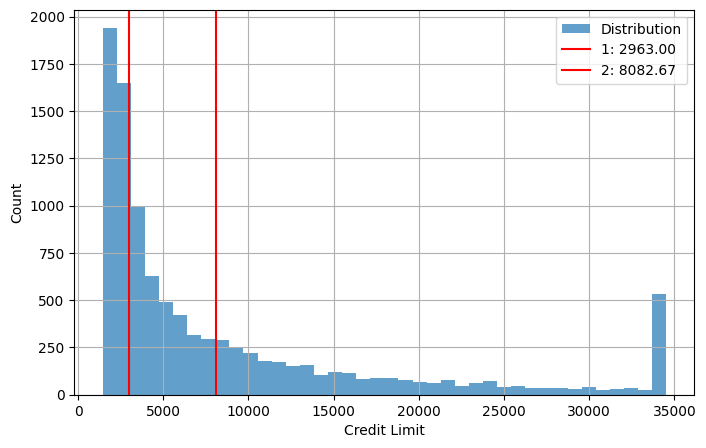

In [7]:
import matplotlib.pyplot as plt

def plot_divisions(y, divisions, title=""):
    plt.figure(figsize=(8,5))
    plt.hist(y, bins=40, alpha=0.7, label="Distribution")

    for i, division in enumerate(divisions):
        plt.axvline(division, color='red', label=f"{i+1}: {division:.2f}")

    plt.title(title)
    plt.xlabel("Credit Limit")
    plt.ylabel("Count")
    plt.legend()
    plt.grid(True)
    plt.show()

def divide_percentile(g, y):
    chunk_size = 100 / g
    divisions = []
    for i in range(1, g): # start at 1 because we don't want to divide at the 0th percentile
        percentile = np.percentile(y, chunk_size * i)
        divisions.append(percentile)
    return divisions

divisions = divide_percentile(3, y)
plot_divisions(y, divisions)

To interpret the graph above, one third of the entries fall below the first division ($\lt 2963.00$) another third fall between the two divisions ($\ge 2963.00$ and $\lt 8082.67$) and the last third fall above the second division ($\ge 8082.67$). In other words, we are dividing the entries into exact thirds so each classification we can make has an equal number of other entries, in the case where $g = 3$ each division contains $33.33 \%$ of the entries. 

Next, we can just divide the entries equally based upon the credit limit itself. Here with *range division* we are dividing the data based upon the range of the credit limit. This will create a variable number of classifications just as `divide_percentile`. 

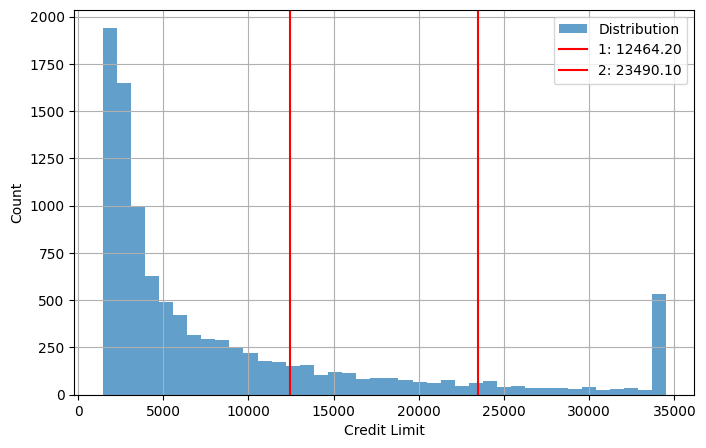

In [9]:
def divide_range(g, y):
    y_min = min(y)
    y_max = max(y)
    step = (y_max - y_min) / g

    divisions = []
    for i in range(1, g):
        divisions.append(y_min + i * step)

    return divisions


divisions = divide_range(3, y)
plot_divisions(y, divisions)

Here you can see that we are creating classification options based on dividing the credit limit range by 3. 

For now we are going to use the binary classification using `divide_percentile(2, y)` in order to classify entries if they are higher or lower than the median, but later on we will discuss the performance of models based upon which method we are using to label the data.

In [27]:
def make_division(y, divisions):
    y = np.array(y)
    divisions = np.array(divisions)
    labels = np.zeros(len(y), dtype=int)
    
    for i, d in enumerate(divisions):
        labels[y > d] = i + 1

    return labels

y_median = np.median(y)
print(f"y median: {y_median}")

# binary classification
divisions = divide_percentile(2, y)
y_percentile_2 = make_division(y, divisions) 

pd.DataFrame({
    "y": y[:5],
    "y_percentile_2": y_percentile_2[:5]
})

y median: 4549.0


,y,y_percentile_2
0,12691.0,1
1,8256.0,1
2,3418.0,0
3,3313.0,0
4,4716.0,1


### K-nearest neighbors

In [51]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_numerical, y_percentile_2, test_size=0.3, random_state=42)

classifier = KNeighborsClassifier(1)
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)
accuracy = np.sum(y_pred == y_test) / len(y_test)
accuracy

np.float64(0.6252056597564989)